In [ ]:
import numpy as np
from datetime import timedelta
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from datetime import date

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__

In [ ]:
%load_ext skip_kernel_extension

In [ ]:
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature,
average_over_year,
average_over_day)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)

# Project Outline


- [Introduction](#introduction)
- [Analyzing Energy dataset](#analyzing-energy-dataset)
- [Analyzing Weather Data](#analyzing-weather-dateset)
- [Feature engineering](#feature-engineering)
- [Baseline models](#baseline-models)
  - [SARIMAX](#sarimax)
  - [SVM](#svm)
- [Advanced models](#advanced-models)
  - [Simple NN](#simple-nn)
  - [RNN](#rnn)
  - [LSTM](#lstm)
- [Hyperparameter Tuning](#hyperparameter-tuning)
- [Conclusion and outlook](#conclusion-and-outlook)


# Introduction


"Climate change is one of the greatest challenges facing humanity, and we, as machine learning experts,
may wonder how we can help. Here we describe how machine learning can be a powerful tool in
reducing greenhouse gas emissions and helping society adapt to a changing climate. \
From smart grids to disaster management, we identify high impact problems where existing gaps can be filled by machine
learning, in collaboration with other fields. Our recommendations encompass exciting research questions
as well as promising business opportunities. We call on the machine learning community to join
the global effort against climate change." \
[David Rolnick et. al., 2019, Tackling Climate Change with Machine Learning](https://arxiv.org/abs/1906.05433)

"This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España. Weather data was purchased as part of a personal project from the Open Weather API for the 5 largest cities in Spain and made public here." \
[Nicholas Jhana, 2019, Hourly energy demand generation and weather](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)

As described, in this project we are presented with two files, containing electrical consumption, generation, pricing and weather data for the region of Spain. \
In total there are up to 45 columns/features in the dataset and the data for each feature is hourly collected from 2015 to 2018, which results in 35064 timesteps.
With a dataset of this size and detail, it is only natural to thing about the application of Machine Learning and Neural Networks. 

On one hand it is interesting to forecast the electrical prices, especially for businesses. On the other hand the prediction of electrical consumption can play a crucial role in our fight against global warming. With accurate predictions on the electrical load and sufficient storage capacities, renewable energy sources, where energy production heavily depends on weather, can be planned ahead in time, stored and used later on, which reduces the necessity for other energy generation methods. In turn this might also have an influence on the price. \
Therefore it is interesting to investigate the dependencies between weather, energy generation, consumption and pricing. \
From intuition one might say that the weather and energy consumption are the most basic and indepent variables in this project, because the energy generation from renewable energy sources are dependent from the weather. The increase and decrease of energy prices depends on the supply and demand, or in our case the generation and consumption. 


![energy graph](./files/energy.jpg)

There are many ways to tackle a problem of this size and complexity. \
So first of all, we should define the goals of this project. This dataset is very suited for short term load forecasting, since the overall dataset has a length of 4 years and the resolution is down to hours. The model should be able to predict features for up to 24 hours into the future. \
For this project we are going to start with analyzing the dataset with statistical methods to get a feel for the dataset itself. \
And with a dataset that rich in features, it would be very beneficial apply Feature engineering methods like Correlation Analysis and Dimensionality Reduction to compress the dataset. \
With data like Weather and Energy demand it is worthwhile to look into seasonal trends and patterns and apply a Decomposition to the dataset. Furthermore, it would be practical to look into the history dependcy of the data and apply Autocorrelation and Partial Autocorrelation functions to analyze the dataset. \
For the Basemodel I choose to approach the task as a Regression Problem and model it with the SARIMAX-Model and the SVR-Model. \
The advanced model will be a neural network. And for this NN we will investigate different architectures to find the most suitable Model for this task. We especially will look into recurrent neural networks for their capability to process past data to predict the future. Furthermore, we will model it in a way, that a direct multistep prediction is possible.\

![model graph](./files/DDE_graphs_1.png)

In [ ]:
SKIP_SARIMAX = True
SKIP_SVM = True
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = True

# Analyzing energy dataset


In [ ]:
df_energy = pd.read_csv("energy_dataset.csv")
df_energy = set_timestamp_index(df_energy, "time")
df_energy

## General Analysis


In [ ]:
df_energy.describe()

In [ ]:
df_energy.hist(bins=50, figsize=(25, 15))
plt.show()

## Data Preparation and Cleaning


### Dataframe cleaning


- Columns with no actual data:
  - generation fossil coal-derived gas
  - generation fossil oil shale
  - generation fossil peat
  - generation geothermal
  - generation hydro pumped storage aggregated
  - generation marine
  - generation wind offshore
  - forecast wind offshore eday ahead
- The Count of values is different from the length of the DataFrame
- Therefore NaN-Values are in the Dataframe


In [ ]:
# remove data with no values
df_energy = remove_columns(
    df_energy,
    [
        "generation fossil coal-derived gas",
        "generation fossil oil shale",
        "generation fossil peat",
        "generation geothermal",
        "generation hydro pumped storage aggregated",
        "generation marine",
        "generation wind offshore",
        "forecast wind offshore eday ahead",
    ],
)
# remove useless data
df_energy = remove_columns(
    df_energy,
    [
        "forecast solar day ahead",
        "forecast wind onshore day ahead",
        "total load forecast",
        "price day ahead",
    ],
)
# interpolate for missing data
df_energy.interpolate(inplace=True)
generation_parameters = [x for x in df_energy.columns if "generation" in x]
energy_parameters = [x for x in df_energy.columns if x not in generation_parameters]
df_energy.describe()

In [ ]:
df_energy.hist(bins=50, figsize=(25, 15))
plt.show()

### Checking for overall length of the dataframe


In [ ]:
date_period = pd.date_range(
    start="2015-01-01 00:00:00+1", end="2018-12-31 23:00:00+1", freq="H"
)
print("Length of the data frames: ", len(df_energy))
print("Length of the time periode: ", len(date_period))

## Checking energy mix

In [ ]:
df_generation = average_over_year(df_energy)
df_generation = remove_columns(df_generation,["total load actual","price actual"])

In [ ]:
months_list = ['January','February','March','April','May','June','July','August','September','October','November','December']
df_generation['month'] = months_list
df_generation.set_index('month',inplace=True)

In [ ]:
fig= px.bar(df_generation)
fig.update_layout(barmode="relative")
fig.show()

In [ ]:
df_generation['sum'] = df_generation.sum(axis=1)
for col in df_generation.columns:
    df_generation[col]= df_generation[col]/df_generation['sum']
df_generation = remove_columns(df_generation,["sum"])

In [ ]:
fig= px.bar(df_generation)
fig.show()

# Analyzing weather dataset


In [ ]:
df_weather = pd.read_csv("weather_features.csv")
df_weather

## General Analysis


In [ ]:
df_weather.describe()

In [ ]:
df_weather.hist(bins=50, figsize=(25, 15))
plt.show()

## Data Preparation and Analysis


### Outlier Handling


- Outliers in:
  - pressure
  - windspeed
- Removing Outliers by masking dataframe
- Data with no useful information:
  - temp_min
  - temp_max
  - rain_1h
  - rain_3h
  - snow_3h
  - clouds_all
  - weather_id
  - weather_main
  - weather_description
  - weather_icon


In [ ]:
# Removing outliers with upper and lower treshhold
df_weather["pressure"].mask(df_weather["pressure"] >= 1.1e3, inplace=True)
df_weather["pressure"].mask(df_weather["pressure"] <= 0.9e3, inplace=True)
df_weather["wind_speed"].mask(df_weather["wind_speed"] >= 15, inplace=True)
# interpolating missing data
df_weather.interpolate(inplace=True)
# dropping columns with no useful data
df_weather = remove_columns(
    df_weather,
    [
        "temp_min",
        "temp_max",
        "rain_1h",
        "rain_3h",
        "snow_3h",
        "clouds_all",
        "weather_id",
        "weather_main",
        "weather_description",
        "weather_icon",
    ],
)
weather_parameters = [x for x in df_weather.columns]

In [ ]:
df_weather.describe()

In [ ]:
df_weather.hist(bins=50, figsize=(25, 15))
plt.show()

### Splitting into city data


In [ ]:
city_list = ["Valencia", "Madrid", "Bilbao", "Barcelona", "Seville"]
df_weather["temp"] = df_weather["temp"].apply(lambda x: x - 273.15)
df_cities = [
    df_weather.query(f"city_name == '{x}'") for x in df_weather.city_name.unique()
]
for i, df in enumerate(df_cities):
    df_cities[i] = set_timestamp_index(df.copy(deep=True), "dt_iso")

In [ ]:
for name, df in zip(city_list, df_cities):
    print(f"Length of the {name} DataFrame: ", len(df))

### Cleaning timeseries


In [ ]:
df_city_duplicates = display_double_timestamps()
df_valencia_duplicates = df_city_duplicates[0]
df_valencia_duplicates

As you can see in the DataFrame the difference mostly occours due to a slight weather change within the hour timestamp.


In [ ]:
for i, item in enumerate(df_cities):
    df_cities[i] = remove_duplicates(item)

for name, df in zip(city_list, df_cities):
    print(f"Length of the {name} DataFrame: ", len(df))

df_valencia = df_cities[0]
df_madrid = df_cities[1]
df_bilbao = df_cities[2]
df_barcelona = df_cities[3]
df_seville = df_cities[4]

# Feature Engineering


In [ ]:
combined_df = pd.concat([df_valencia, df_energy], axis=1)
combined_df = remove_columns(combined_df, ["city_name"])

## General Feature Extension


In [ ]:
combined_df["generation"] = combined_df[generation_parameters].sum(axis=1)
combined_df["energy_difference"] = (
    combined_df["generation"] - combined_df["total load actual"]
)

## Time Feature Extension


In [ ]:
combined_df["month"] = combined_df.index.month
combined_df["day"] = combined_df.index.day
combined_df["weekend"] = np.where(df.index.weekday <= 4, 0, 1)
combined_df

## Data Scaling


In [ ]:
featuresToScale = combined_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df = combined_df.copy(deep=True)
scaled_df.loc[:, featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])
scaled_df.sort_index(inplace=True)
scaled_df.describe()

## Correlation Matrix


In [ ]:
correlationMatrix = pd.DataFrame(scaled_df).corr()
f = plt.figure(figsize=(25, 25))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(scaled_df.shape[1]), scaled_df.columns, fontsize=14, rotation=90)
plt.yticks(range(scaled_df.shape[1]), scaled_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [ ]:
correlations = extract_correlations(correlationMatrix, 0.5, -0.4)
for item in correlations:
    print(item)

## PCA Analysis


In [ ]:
n_components = None
whiten = False
svd_solver = "auto"
random_state = 2020

pca = PCA(
    n_components=n_components,
    whiten=whiten,
    svd_solver=svd_solver,
    random_state=random_state,
)
x_pca = pca.fit(scaled_df)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")

In [ ]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(scaled_df) 
print(pca.n_components_)  

In [ ]:
pd.DataFrame(pca.components_, columns=scaled_df.columns)

In [ ]:
n_pcs = pca.n_components_
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = scaled_df.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
print("Most important components:")
for item in most_important_names:
    print(item)
print("")
print("Least important components:")
for item in scaled_df.columns:
    if item not in most_important_names:
        print(item)


## Decomposition


In [ ]:
fig = display_seasonal_decomposition(
    scaled_df["2015-01-01 00:00:00":"2015-12-31 23:00:00"],
    "total load actual",
    48,
    "median",
)

## Autocorrelation and Partial Autocorrelation


In [ ]:
plt.figure()
lag_plot(combined_df["total load actual"])

In [ ]:
plt.figure()
autocorrelation_plot(combined_df["total load actual"])

In [ ]:
plt.figure()
subset = combined_df["total load actual"]["2015-01-01":"2015-01-07"]
autocorrelation_plot(subset)

In [ ]:
plt.figure()
plot_acf(combined_df["total load actual"])

In [ ]:
plot_pacf(combined_df["total load actual"], lags=25)

# Baseline Models


In [ ]:
combined_df

## SARIMAX


In [ ]:
%%skip $SKIP_SARIMAX

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

### Singlestep prediction


Creating test-train-split datasets


In [ ]:
%%skip $SKIP_SARIMAX

train_start = "2015-01-01"
test_start = "2017-01-01"
test_end = "2017-01-02"
combined_df.index.freq = "h"
modeltype = 'SARIMAX'
namespace = "SARIMAX"
feature = 'total load actual'
exog_feature = 'temp'

data_y_train,data_y_test,data_exog_train,data_exog_test = create_sarimax_test_train_split(combined_df,feature,exog_feature,train_start=train_start,test_start=test_start,test_end=test_end,)


Scaling dataset with MinMaxScaler


In [ ]:
%%skip $SKIP_SARIMAX

scaler_1 = pp.MinMaxScaler()
scaler_2 = pp.MinMaxScaler()
data_y_train[feature] = scaler_1.fit_transform(data_y_train)
data_y_test[feature] = scaler_1.transform(data_y_test)

data_exog_train[exog_feature] = scaler_2.fit_transform(data_exog_train)
data_exog_test[exog_feature] = scaler_2.transform(data_exog_test)

Hyperparameter setttings for SARIMAX

In [ ]:
%%skip $SKIP_SARIMAX

horizon = 1
order = (3, 2, 8)
seasonal_order = (1, 1, 1, 24)
exog = data_exog_train

Preparing data for SARIMAX


In [ ]:
%%skip $SKIP_SARIMAX

test_ts, history, predictions, history_temp, predictions_temp = prepare_data_sarimax(
    data_y_train = data_y_train,
    data_y_test = data_y_test,
    exog_y_train = data_exog_train,
    exog_y_test = data_exog_test,
    horizon = horizon,
    training_window=720,
    feature=feature,
    exog_feature=exog_feature,
)

Model Predictions


In [ ]:
%%skip $SKIP_SARIMAX

for t in range(0, test_ts.shape[0], horizon):

    model = SARIMAX(
        endog=history, exog=history_temp, order=order, seasonal_order=seasonal_order
    )
    model_fit = model.fit()
    y_p = model_fit.forecast(
        steps=horizon, exog=predictions_temp.iloc[:horizon].to_frame()
    ).tolist()

    obs = list(test_ts.iloc[t])
    predictions.extend(y_p)

    history = history.append(
        pd.Series(
            y_p,
            index=pd.date_range(
                start=history.index[-1] + timedelta(hours=1), periods=horizon, freq="h"
            ),
        )
    )
    history = history[horizon:]

    history_temp = history_temp.append(predictions_temp.iloc[:horizon])
    history_temp.drop(index=history_temp.index[:horizon], inplace=True)
    predictions_temp.drop(index=predictions_temp.index[:horizon], inplace=True)

    print(test_ts.index[t])
    print(t + 1, ": predicted =", y_p, "true value =", obs)



Create eval_df


In [ ]:
%%skip $SKIP_SARIMAX

eval_df = pd.DataFrame(predictions)
eval_df.columns = ['prediction']
eval_df=(eval_df.set_index(data_y_test.index)) 
eval_df['actual'] = data_y_test
eval_df[['prediction', 'actual']] = scaler_1.inverse_transform(eval_df[['prediction', 'actual']])

In [ ]:
%%skip $SKIP_SARIMAX

fig = plot_predictions(eval_df,horizon,modeltype,feature,f"./{modeltype}/predictions_{namespace}")

In [ ]:
%%skip $SKIP_SARIMAX

fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}")

In [ ]:
%%skip $SKIP_SARIMAX

fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}")

In [ ]:
%%skip $SKIP_SARIMAX

Score_sarimax = r2_score(eval_df['actual'],eval_df['prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

### Multistep Prediction


Creating test-train-split datasets


In [ ]:
%%skip $SKIP_SARIMAX

train_start = "2015-01-01"
test_start = "2017-01-01"
test_end = "2017-01-02"
modeltype = 'SARIMAX'
namespace = "MS_SARIMAX"
feature = 'total load actual'
exog_feature = 'temp'
combined_df.index.freq = "h"

data_y_train,data_y_test,data_exog_train,data_exog_test = create_sarimax_test_train_split(combined_df,'total load actual','temp',train_start=train_start,test_start=test_start,test_end=test_end,)


Scaling dataset with MinMaxScaler


In [ ]:
%%skip $SKIP_SARIMAX

scaler_1 = pp.MinMaxScaler()
scaler_2 = pp.MinMaxScaler()
data_y_train[feature] = scaler_1.fit_transform(data_y_train)
data_y_test[feature] = scaler_1.transform(data_y_test)

data_exog_train[exog_feature] = scaler_2.fit_transform(data_exog_train)
data_exog_test[exog_feature] = scaler_2.transform(data_exog_test)

Hyperparameter setttings for SARIMAX


In [ ]:
%%skip $SKIP_SARIMAX

horizon = 6
order = (3, 2, 8)
seasonal_order = (1, 1, 1, 24)
exog = data_exog_train

Preparing data for SARIMAX


In [ ]:
%%skip $SKIP_SARIMAX

test_ts, history, predictions, history_temp, predictions_temp = prepare_data_sarimax(
    data_y_train = data_y_train,
    data_y_test = data_y_test,
    exog_y_train = data_exog_train,
    exog_y_test = data_exog_test,
    horizon = horizon,
    training_window=720,
    feature=feature,
    exog_feature=exog_feature,
)

Model Predictions


In [ ]:
%%skip $SKIP_SARIMAX

for t in range(0, test_ts.shape[0], horizon):

    model = SARIMAX(
        endog=history, exog=history_temp, order=order, seasonal_order=seasonal_order
    )
    
    model_fit = model.fit()
    
    y_p = model_fit.forecast(
        steps=horizon, exog=predictions_temp.iloc[:horizon].to_frame()
    ).tolist()

    obs = list(test_ts.iloc[t])
    predictions.extend(y_p)

    history = history.append(
        pd.Series(
            y_p,
            index=pd.date_range(
                start=history.index[-1] + timedelta(hours=1), periods=horizon, freq="h"
            ),
        )
    )
    history = history[horizon:]

    history_temp = history_temp.append(predictions_temp.iloc[:horizon])
    history_temp.drop(index=history_temp.index[:horizon], inplace=True)
    predictions_temp.drop(index=predictions_temp.index[:horizon], inplace=True)

    print(test_ts.index[t])
    print(t + 1, ": predicted =", y_p, "true value =", obs)



Create eval_df


In [ ]:
%%skip $SKIP_SARIMAX

eval_df = pd.DataFrame(predictions)
eval_df.columns = ['prediction']
eval_df=(eval_df.set_index(data_y_test.index)) 
eval_df['actual'] = data_y_test[feature]
eval_df[['prediction', 'actual']] = scaler_1.inverse_transform(eval_df[['prediction', 'actual']])

In [ ]:
%%skip $SKIP_SARIMAX

fig = plot_predictions(eval_df,horizon,modeltype,feature,f"./{modeltype}/predictions_{namespace}")

In [ ]:
%%skip $SKIP_SARIMAX

fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}")

In [ ]:
%%skip $SKIP_SARIMAX

fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}")

In [ ]:
%%skip $SKIP_SARIMAX

Score_sarimax = r2_score(eval_df['actual'],eval_df['prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

## SVM


### Singlestep prediction


Loading the data set

In [ ]:
%%skip $SKIP_SVM

scaled_df = combined_df.copy(deep=True)

Scaling the data set

In [ ]:
%%skip $SKIP_SVM

featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Creating Test-Train split

In [ ]:
%%skip $SKIP_SVM

train_start = '2015-01-01'
test_start = '2017-01-01'
test_end = '2017-01-04'
scaled_df.index.freq = 'h' 
feature = 'total load acutal'
namespace = 'SVR'
modeltype = 'SVR'
feature_df = combined_df[feature]
(
    data_x_train,
    data_x_test,
    data_y_train,
    data_y_test,

) = create_test_train_split(
    df_x=scaled_df,df_y=feature_df,train_start=train_start,test_start=test_start,test_end=test_end,)


Hyperparameters

In [ ]:
%%skip $SKIP_SVM

kernel='linear' 
gamma='scale'
epsilon=0.1    
shrinking=True 
tol=0.00001

svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

Fitting the model to the training data

In [ ]:
%%skip $SKIP_SVM

model = svr
model.fit(data_x_train, data_y_train)

Getting model prediction scores

In [ ]:
%%skip $SKIP_SVM

scoreTraining = model.score(data_x_train, data_y_train)
print('-----------------------------------')
print('SVM Regression Training R^2 Score: ', scoreTraining)
print('-----------------------------------')
scoreValidation = model.score(data_x_test, data_y_test)
print('-----------------------------------')
print('SVM Regression Validation R^2 Score: ', scoreValidation)
print('-----------------------------------')

Model predictions

In [ ]:
%%skip $SKIP_SVM

y_predict = pd.Series(svr.predict(data_x_test),index=data_y_test.index)

In [ ]:
%%skip $SKIP_SVM

plt.figure();
plt.plot(data_y_test, 'k.-');
plt.plot(y_predict, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead for 72 hours'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

### Multistep prediction


Loading the data set

In [ ]:
%%skip $SKIP_SVM

scaled_df = combined_df.copy(deep=True)

Scaling the data set

In [ ]:
%%skip $SKIP_SVM

featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Creating Test-Train split

In [ ]:
%%skip $SKIP_SVM

train_start = '2015-01-01'
test_start = '2017-01-01'
test_end = '2017-01-04'
scaled_df.index.freq = 'h' 
feature = 'total load acutal'
namespace = 'MS_SVR'
modeltype = 'SVR'
feature_df = combined_df[feature]
(
    data_x_train,
    data_x_test,
    data_y_train,
    data_y_test,

) = create_test_train_split(
    df_x=scaled_df,df_y=feature_df,train_start=train_start,test_start=test_start,test_end=test_end,)


Hyperparameters

In [ ]:
%%skip $SKIP_SVM

pd.options.mode.chained_assignment = None 

kernel='linear' 
gamma='scale' 
epsilon=0.1    
shrinking=True 
tol=0.00001

svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

Fitting the model to the training data

In [ ]:
%%skip $SKIP_SVM

model = svr
model.fit(data_x_train, data_y_train)

In [ ]:
%%skip $SKIP_SVM

y_predicted =pd.Series(index=data_y_test.index)

Model predictions

In [ ]:
%%skip $SKIP_SVM

case_indices = data_y_test.index
window = 720
start_case_index = case_indices[0]-timedelta(hours=window)
end_case_index = case_indices[0]-timedelta(hours=1)
data_x_last = scaled_df[start_case_index:end_case_index]
dummy_array = np.zeros((1,data_x_last.shape[1])) 

for case_index in case_indices:

  load_prediction = svr.predict(data_x_last).flatten()[0]

  y_predicted.update(pd.Series(load_prediction,index=[case_index]))

  dummy_array[0,data_x_last.shape[1]-1] = load_prediction
  load_scaled = sX.transform(dummy_array)[0,data_x_last.shape[1]-1]
  
  start_case_index = case_index-timedelta(hours=window-1)
  end_case_index=case_index

  data_x_last = scaled_df[start_case_index:end_case_index]
  data_x_last.loc[case_index,'total load actual'] = load_scaled


In [ ]:
%%skip $SKIP_SVM

plt.figure();
plt.plot(data_y_test, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead for 72 hours'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');

# Advanced Models

## Simple NN


Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'total load actual'
namespace = 'NN'
modeltype = 'NN'
feature_df = combined_df[[feature]]
data_x_train,data_x_val,data_x_test,data_y_train,data_y_val,data_y_test = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)


Define the Model

In [ ]:
def build_model_batch():
  model = models.Sequential([
  layers.Dense(32, kernel_initializer="he_normal", input_shape=(data_x_train.shape[1],)),keras.layers.LeakyReLU(alpha=0.1),                           
  layers.BatchNormalization(),
  layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(1)
  ])
  
  model.compile(optimizer='Adam', loss=['mse'], metrics=['mae'])
  return model


In [ ]:
build_model_batch().summary()

Define Callback functions

In [ ]:
myCheckpoint= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stopping = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

Hyperparameters

In [ ]:
num_epochs = 100
batch_size = 10

Training the model

In [ ]:
%%skip $SKIP_RETRAIN_NN

model_base = build_model_batch()
history_base = model_base.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                callbacks=[myCheckpoint,myEarly_stopping])

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_NN

hist = pd.DataFrame(history_base.history)
hist['epoch'] = history_base.epoch

In [ ]:
%%skip $SKIP_RETRAIN_NN

fig = plot_learning_curves(hist,modeltype, f"./{modeltype}/learningcurve_{namespace}")

Load best model

In [ ]:
model_best = keras.models.load_model(f"my_best_model_{namespace}.h5")
model_best.summary()

Evaluate Predictions

In [ ]:
Y_test_predictions = pd.Series(model_best.predict(data_x_test).flatten(),index=data_x_test.index)

In [ ]:
eval_df = create_eval_df(Y_test_predictions,data_y_test,)

In [ ]:
fig = plot_accuracy(eval_df,modeltype, f"./{modeltype}/accuracy_{namespace}")

In [ ]:
fig = plot_error_variations(eval_df,modeltype, f"./{modeltype}/error_variations_{namespace}")

In [ ]:
abs_error_nn = abs(Y_test_predictions - data_y_test)/data_y_test*100
np.average(abs_error_nn)


In [ ]:
r2_test = r2_score(data_y_test, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
fig = plot_predictions(eval_df,1,modeltype,feature ,f"./{modeltype}/predictions_{namespace}")

## RNN

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'total load actual'
namespace = "RNN"
modeltype = "RNN"
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24,1,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24,1,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24,1,32)

In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

Define RNN Model

In [ ]:
def build_model_RNN(data_x_train,data_y_train):
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential([
    layers.SimpleRNN(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
    layers.BatchNormalization(),
    layers.SimpleRNN(32, return_sequences=True, stateful=False),
    layers.BatchNormalization(),
    layers.SimpleRNN(32, stateful=False),
    layers.BatchNormalization(),
    layers.Dense(n_outputs)                     
    ])
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

Define Callback functions

In [ ]:
myCheckpointRNN= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingRNN = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

Hyperparameters

In [ ]:
num_epochs = 150
batch_size = 32

Training the Model

In [ ]:
%%skip $SKIP_RETRAIN_RNN

model_rnn = build_model_RNN(data_x_train,data_y_train)
history_rnn = model_rnn.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointRNN,myEarly_stoppingRNN])#, verbose=0)



Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_RNN

histRNN = pd.DataFrame(history_rnn.history)
histRNN['epoch'] = history_rnn.epoch

In [ ]:
%%skip $SKIP_RETRAIN_RNN

fig = plot_learning_curves(histRNN,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [ ]:
model_best_RNN = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_RNN.summary()

Evaluate predictions

In [ ]:
y_test_filtered = data_y_test0.loc[idx_test]
y_test_filtered = y_test_filtered.squeeze(axis=1)
Y_test_predictions = pd.Series(model_best_RNN.predict(data_x_test).flatten(),index=y_test_filtered.index)

In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

In [ ]:
fig = plot_accuracy( eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}.png" )

In [ ]:
fig = plot_error_variations(eval_df,,modeltype,f"./{modeltype}/error_variations_{namespace}.png")

In [ ]:
abs_error_rnn = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_rnn)

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
fig = plot_predictions(eval_df,1,modeltype,feature,f"./{modeltype}/predictions_{namespace}.png")

## Single Step LSTM

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'total load actual'
namespace = 'LSTM'
modeltype = 'LSTM'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24,1,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24,1,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24,1,32)

In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

Define LSTM Model

In [ ]:
def build_model_LSTM(data_x_train,data_y_train):
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential([
    layers.LSTM(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
    layers.BatchNormalization(),
    layers.LSTM(32, return_sequences=True, stateful=False),
    layers.BatchNormalization(),
    layers.LSTM(32, stateful=False),
    layers.BatchNormalization(),
    layers.Dense(n_outputs)                     
    ])
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

Definening callback functions

In [ ]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

Hypterparameters

In [ ]:
num_epochs = 150
batch_size = 32

Training the model

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

model_LSTM = build_model_LSTM(data_x_train,data_y_train)
history_LSTM = model_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])#, verbose=0)

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM['epoch'] = history_LSTM.epoch

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [ ]:
model_best_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_LSTM.summary()

In [ ]:
Y_test_predictions = pd.Series(model_best_LSTM.predict(data_x_test).flatten(),index=y_test_filtered.index)
y_test_filtered = data_y_test0.loc[idx_test]
y_test_filtered =y_test_filtered.squeeze(axis=1)

In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

In [ ]:
fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}.png")

In [ ]:
fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}.png")

In [ ]:
abs_error_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_LSTM)

In [ ]:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
fig = plot_predictions(eval_df,1,modeltype,feature,f"./{modeltype}/learningcurve_{namespace}.png")

## Mulitstep LSTM

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
scaled_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.807250,-1.254819,0.605043,-0.724273,-0.820537,0.743671,-0.335844,-0.353717,0.287706,-2.596050,...,-0.823732,-1.462008,0.284116,-0.724094,0.529854,-0.092704,1.133008,-1.601685,-1.673784,-0.633062
2015-01-01 01:00:00+01:00,-2.807250,-1.254819,0.605043,-0.724273,-0.820537,0.767106,-0.338664,-0.193824,0.254067,-2.672213,...,-0.823137,-1.481921,0.132259,-0.943292,0.495356,-0.196137,1.353784,-1.601685,-1.673784,-0.633062
2015-01-01 02:00:00+01:00,-2.916311,-1.171050,0.655861,-1.161697,-1.144428,0.755388,-0.352763,-0.347812,0.165380,-2.691253,...,-0.823137,-1.462008,-0.001239,-1.303451,0.464379,-0.440270,1.596250,-1.601685,-1.673784,-0.633062
2015-01-01 03:00:00+01:00,-2.916311,-1.171050,0.655861,-1.161697,-1.144428,0.638217,-0.547342,-0.594464,-0.063983,-2.634131,...,-0.823137,-1.561575,-0.070633,-1.619900,0.101098,-0.816024,1.547834,-1.601685,-1.673784,-0.633062
2015-01-01 04:00:00+01:00,-2.916311,-1.171050,0.655861,-1.161697,-1.144428,0.521046,-0.736280,-0.678044,-0.212304,-2.710294,...,-0.827899,-1.601401,-0.164921,-1.843251,-0.129825,-0.960067,1.710124,-1.601685,-1.673784,-0.633062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,-0.711034,1.006965,-0.157230,-0.286850,-0.172756,-1.013900,-1.263615,0.913613,-0.830053,-2.291399,...,-0.802303,0.150969,-0.731897,0.427190,1.347236,-0.531282,-1.618560,1.587925,1.735195,-0.633062
2018-12-31 20:00:00+01:00,-1.056602,1.090734,0.300134,-0.724273,0.674344,-1.025617,-1.263615,0.735096,-0.861654,-2.367562,...,-0.833256,0.210709,-0.677440,0.226567,1.286689,-0.818413,-1.728560,1.587925,1.735195,-0.633062
2018-12-31 21:00:00+01:00,-1.261179,1.090734,0.808315,0.150573,1.156028,-1.072486,-1.263615,0.636980,-0.935050,-2.481806,...,-0.834447,0.330188,-0.610535,-0.137088,1.155739,-1.111276,-1.558911,1.587925,1.735195,-0.633062
2018-12-31 22:00:00+01:00,-1.471284,1.090734,0.808315,-0.286850,1.239077,-1.060769,-1.263615,0.426667,-1.000800,-2.577009,...,-0.834447,0.350102,-0.584707,-0.633180,0.845260,-1.407245,-1.159578,1.587925,1.735195,-0.633062


In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-14'
feature = 'total load actual'
model_type = 'LSTM'
namespace = 'MS_LSTM_LOAD'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17416, 72, 26) (17416, 24)
(1288, 72, 26) (1288, 24)
(168, 72, 26) (168, 24)


Define LSTM Model

In [ ]:
def build_model_LSTM(data_x_train,data_y_train):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential([
  layers.LSTM(64, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, stateful=False),
  layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),
  layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(n_outputs),              
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model

Definening callback functions

In [ ]:
myCheckpointMSLSTM= keras.callbacks.ModelCheckpoint(f"./{model_type}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingMSLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

Hypterparameters

In [ ]:
num_epochs = 150
batch_size = 32

Training the model

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

model_MSLSTM = build_model_LSTM(data_x_train,data_y_train)
history_MSLSTM = model_MSLSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

Epoch 1/150
545/545 [==============================] - 23s 33ms/step - loss: 829088512.0000 - mae: 28435.9043 - val_loss: 901478400.0000 - val_mae: 29603.0195
Epoch 2/150
545/545 [==============================] - 17s 31ms/step - loss: 823088192.0000 - mae: 28342.0820 - val_loss: 895819328.0000 - val_mae: 29515.8887
Epoch 3/150
545/545 [==============================] - 17s 31ms/step - loss: 812134912.0000 - mae: 28165.3535 - val_loss: 878735488.0000 - val_mae: 29237.9688
Epoch 4/150
545/545 [==============================] - 17s 31ms/step - loss: 797313664.0000 - mae: 27920.0762 - val_loss: 848305472.0000 - val_mae: 28723.7422
Epoch 5/150
545/545 [==============================] - 17s 32ms/step - loss: 779359232.0000 - mae: 27615.8477 - val_loss: 815250816.0000 - val_mae: 28147.8691
Epoch 6/150
545/545 [==============================] - 17s 32ms/step - loss: 758927232.0000 - mae: 27259.6660 - val_loss: 784850112.0000 - val_mae: 27592.8223
Epoch 7/150
545/545 [=========================

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

histMSLSTM = pd.DataFrame(history_MSLSTM.history)
histMSLSTM['epoch'] = history_MSLSTM.epoch

<string>:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



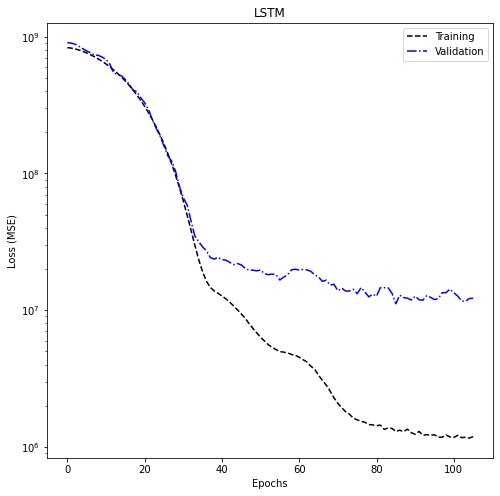

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histMSLSTM,model_type,f'./{model_type}/learningcurve_{namespace}.png')
fig.show()

Load best model

In [ ]:
model_best_MS_LSTM = keras.models.load_model(f"./{model_type}/my_best_model_{namespace}.h5")
model_best_MS_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          23296     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          3

In [ ]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))

Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]


In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

<ipython-input-47-f128fcf0dccf>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



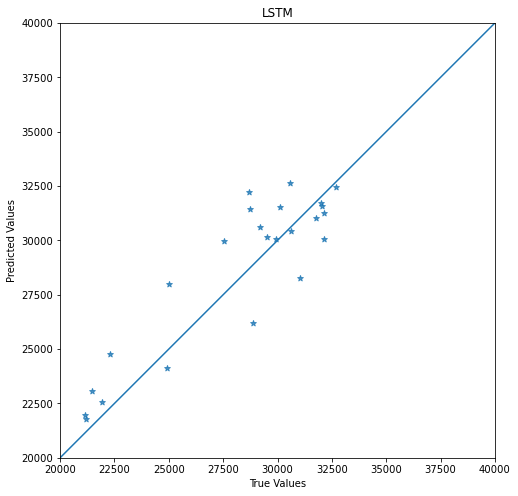

In [ ]:
fig = plot_accuracy(eval_df,model_type,f"./{model_type}/accuracy_{namespace}.png")
fig.show()

<ipython-input-48-05c98d64636b>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



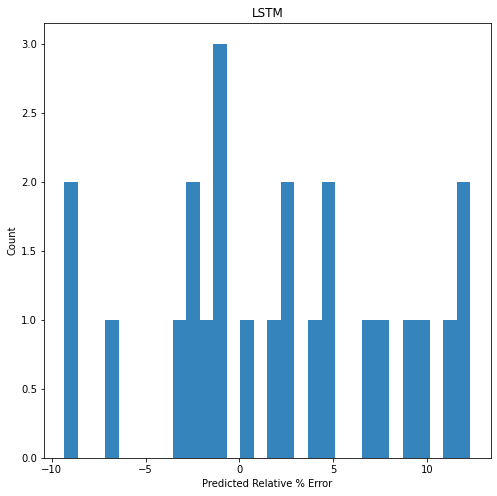

In [ ]:
fig = plot_error_variations(eval_df,model_type,f"./{model_type}/error_variations_{namespace}.png")
fig.show()

In [ ]:
abs_error_MSLSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_MSLSTM)

nan

In [ ]:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.79


<ipython-input-51-c54bd844a7ce>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



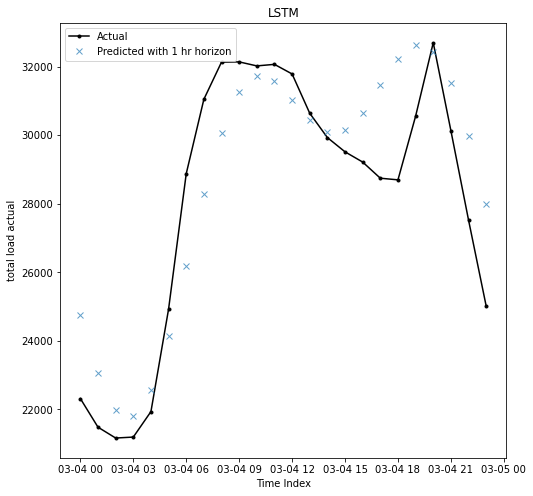

In [ ]:
fig = plot_predictions(eval_df,1,model_type,feature,f"./{model_type}/predictions_{namespace}")
fig.show()

In [ ]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [ ]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2[feature]))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['median']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.77


## Encoder-Decoder + LSTM

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-14'
feature = 'total load actual'
namespace= 'MS_EDLSTM_LOAD'
modeltype = 'EDLSTM'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

Define ED LSTM Model

In [ ]:
def build_model_ED_LSTM(data_x_train,data_y_train):
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential([
    layers.LSTM(80, return_sequences=True,input_shape=(None, n_features), stateful=False),
    layers.BatchNormalization(),
    layers.LSTM(64, return_sequences=True, stateful=False),
    layers.BatchNormalization(),
    layers.LSTM(32, return_sequences=False, stateful=False),
    layers.BatchNormalization(),
    layers.RepeatVector(n_outputs),
    # define decoder:
    layers.LSTM(32, return_sequences=True, stateful=False),
    layers.BatchNormalization(),
    layers.LSTM(64, return_sequences=True, stateful=False),
    layers.BatchNormalization(),
    layers.LSTM(80, return_sequences=True, stateful=False),
    layers.BatchNormalization(),
    layers.TimeDistributed(layers.Dense(1))                     
    ])
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model


Definening callback functions

In [ ]:
myCheckpointEDLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingEDLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

Hypterparameters

In [ ]:
num_epochs = 150
batch_size = 32

Training the model

In [ ]:
model_ED_LSTM = build_model_ED_LSTM(data_x_train,data_y_train)
model_ED_LSTM.summary()


In [ ]:
%%skip $SKIP_RETRAIN_ED_LSTM

history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointEDLSTM,myEarly_stoppingEDLSTM])

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_ED_LSTM

histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
histEDLSTM['epoch'] = history_ED_LSTM.epoch

In [ ]:
%%skip $SKIP_RETRAIN_ED_LSTM

fig = plot_learning_curves(histEDLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")
fig.show()

Load best model

In [ ]:
#Calling back the best model:
model_best_ED_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_ED_LSTM.summary()

In [ ]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]


In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

In [ ]:
fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}.png")
fig.show()

In [ ]:
fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}.png")
fig.show()

In [ ]:
abs_error_ED_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_ED_LSTM)

In [ ]:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
fig=plot_predictions(eval_df,1,model_type,feature,f"./{modeltype}/predictions_{namespace}.png")
fig.show()

In [ ]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [ ]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2[feature]))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['median']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [ ]:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

# Hyperparameter Tuning


We may investigate the following parameters:

*   Number of layers
*   Number of nodes
*   Activation function
*   Optimizer
*   Learning rate
*   Number of epochs 
*   Batch size to update the optimization

Other options we can include can be listed as:

*   Adding weight regularization
*   Adding dropout
*   Early stopping / Callback

## LSTM Hyperparameter Tuning

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-14'
feature = 'total load actual'
modeltype = 'LSTM'
namespace = 'MS_LSTM_LOAD_HPT'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

Define LSTM Model for Hyperparamter Tuning 


In [ ]:
def build_model_LSTM(hp):
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential()
    
    model.add(layers.LSTM(hp.Int('Neurons',min_value=16,max_value=96,step=16), return_sequences=True,input_shape=(None, n_features), stateful=False)) 
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('Dropout',min_value=0.1,max_value=0.4,step=0.1)))
    
    for i in range(hp.Int('n_layers',1,4,1)):
      model.add(layers.LSTM(hp.Int('Neurons',min_value=16,max_value=96,step=16), return_sequences=True, stateful=False))
      model.add(layers.BatchNormalization())
      model.add(layers.Dropout(hp.Float('Dropout',min_value=0.1,max_value=0.4,step=0.1)))
      
    model.add(layers.LSTM(hp.Int('Neurons',min_value=16,max_value=96,step=16), stateful=False))
    
    model.add(layers.Dense(hp.Int('Neurons',min_value=16,max_value=96,step=16), kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),)
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(n_outputs))                     
    
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model_LSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial = 1,
    directory = "./hpt_LSTM/",
    project_name="Load")
tuner.search_space_summary()


In [ ]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [ ]:
num_epochs = 150
batch_size = 32

In [ ]:
tuner.search(data_x_train,data_y_train,epochs=150,validation_data=(data_x_val,data_y_val),batch_size=batch_size,callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

In [ ]:
tuner.results_summary()

In [ ]:
best_models = tuner.get_best_models()
best_hps = tuner.get_best_hyperparameters(5)

In [ ]:
best_hps[0]

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

model_LSTM= build_model_LSTM(best_hps[1])
history_LSTM = model_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM['epoch'] = history_LSTM.epoch

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histLSTM,modeltype,f'./{modeltype}/learningcurve_{namespace}.png')
fig.show()

Load best model

In [ ]:
model_best_MS_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_MS_LSTM.summary()

In [ ]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))

Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]

In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

In [ ]:
fig = plot_accuracy(eval_df,modeltype,f'./{modeltype}/accuracy_{namespace}.png')
fig.show()

In [ ]:
fig = plot_error_variations(eval_df,modeltype,f'./{modeltype}/error_variations_{namespace}.png')
fig.show()

In [ ]:
abs_error_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_LSTM)

In [ ]:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
fig = plot_predictions(eval_df,1,modeltype,feature,f'./{modeltype}/predictions_{namespace}.png')
fig.show()

In [ ]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [ ]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2[feature]))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['median']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [ ]:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

## ED-LSTM Hyperparameter Tuning

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-14'
feature = 'total load actual'
namespace= 'MS_EDLSTM_LOAD_HPT'
model_type = 'EDLSTM'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17416, 72, 26) (17416, 24)
(1288, 72, 26) (1288, 24)
(168, 72, 26) (168, 24)


Define LSTM Model

In [ ]:
def build_model_ED_LSTM(hp):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential()
  # Encoder
  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,input_shape=(None, n_features), stateful=False)) 
  model.add(layers.BatchNormalization())
  
  for i in range(hp.Int('n_layers',1,4,1)):
    model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True, stateful=False))
    model.add(layers.BatchNormalization())
  
  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=False, stateful=False)) 
  model.add(layers.BatchNormalization())  
  
  # Repeat Vector
  model.add(layers.RepeatVector(n_outputs))
  
  # Decoder
  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,stateful=False))
  model.add(layers.BatchNormalization())

  for i in range(hp.Int('n_layers',1,4,1)):
      model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True, stateful=False))
      model.add(layers.BatchNormalization())

  model.add(layers.LSTM(hp.Int('Neurons',min_value=32,max_value=96,step=16), return_sequences=True,stateful=False))
  model.add(layers.BatchNormalization())

  # End
  model.add(layers.TimeDistributed(layers.Dense(1)))                     
              
  
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model

In [ ]:
tuner = kt.RandomSearch(
    build_model_ED_LSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial = 1,
    directory = "./hpt_ED_LSTM/",
    project_name="DDE_2")
tuner.search_space_summary()


INFO:tensorflow:Reloading Oracle from existing project ./hpt_ED_LSTM/DDE_2\oracle.json
INFO:tensorflow:Reloading Tuner from ./hpt_ED_LSTM/DDE_2\tuner0.json
Search space summary
Default search space size: 2
Neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}


In [ ]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{model_type}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [ ]:
num_epochs = 150
batch_size = 32

In [ ]:
tuner.search(data_x_train,data_y_train,epochs=150,validation_data=(data_x_val,data_y_val),batch_size=batch_size,callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in ./hpt_ED_LSTM/DDE_2
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Neurons: 80
n_layers: 2
Score: 6554375.0
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 1
Score: 6809337.0
Trial summary
Hyperparameters:
Neurons: 80
n_layers: 3
Score: 7097545.0
Trial summary
Hyperparameters:
Neurons: 64
n_layers: 3
Score: 7223991.5
Trial summary
Hyperparameters:
Neurons: 96
n_layers: 3
Score: 8044475.5
Trial summary
Hyperparameters:
Neurons: 32
n_layers: 4
Score: 9238089.0
Trial summary
Hyperparameters:
Neurons: 48
n_layers: 2
Score: 9645877.0
Trial summary
Hyperparameters:
Neurons: 32
n_layers: 2
Score: 9690508.0
Trial summary
Hyperparameters:
Neurons: 48
n_layers: 3
Score: 10513382.0
Trial summary
Hyperparameters:
Neurons: 32
n_layers: 3
Score: 10803020.0


In [ ]:
best_models = tuner.get_best_models()
best_hps = tuner.get_best_hyperparameters(5)

In [ ]:
best_hps[0]

In [ ]:
%%skip $SKIP_RETRAIN_ED_LSTM
model_ED_LSTM= build_model_ED_LSTM(best_hps[0])
history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

In [ ]:
%%skip $SKIP_RETRAIN_ED_LSTM
histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
histEDLSTM['epoch'] = history_ED_LSTM.epoch

In [ ]:
%%skip $SKIP_RETRAIN_ED_LSTM
fig = plot_learning_curves(histEDLSTM,model_type,f"./{model_type}/learningcurve_{namespace}.png")
fig.show()

Load best model

In [ ]:
#Calling back the best model:
model_best_ED_LSTM = keras.models.load_model(f"./{model_type}/my_best_model_{namespace}.h5")
model_best_ED_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 80)          34240     
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 80)          320       
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 80)          51520     
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 80)          320       
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 80)          51520     
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 80)          320       
_________________________________________________________________
lstm_11 (LSTM)               (None, 80)               

In [ ]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]

In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

<ipython-input-27-f128fcf0dccf>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


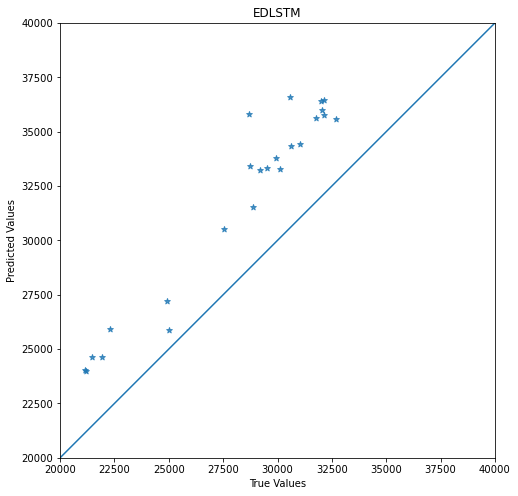

In [ ]:
fig = plot_accuracy(eval_df,model_type,f"./{model_type}/accuracy_{namespace}.png")
fig.show()

<ipython-input-28-05c98d64636b>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


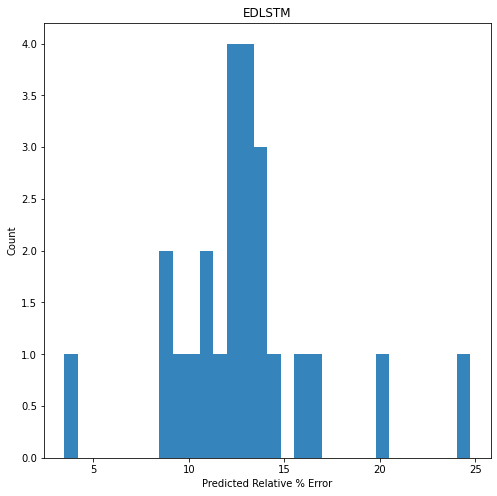

In [ ]:
fig = plot_error_variations(eval_df,model_type,f"./{model_type}/error_variations_{namespace}.png")
fig.show()

In [ ]:
#Calculating the mean absolutepercentage error:
abs_error_ED_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_ED_LSTM)

nan

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.04


<ipython-input-31-65a49c2caced>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


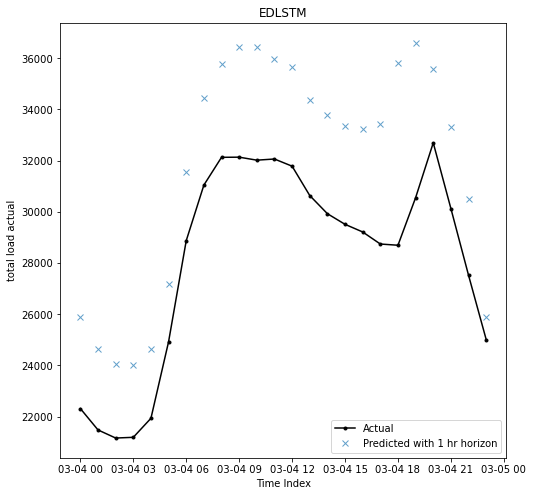

In [ ]:
fig=plot_predictions(eval_df,1,model_type,feature,f"./{model_type}/predictions_{namespace}.png")
fig.show()

In [ ]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [ ]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2[feature]))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    #fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.68


<ipython-input-36-c9c5c3e61439>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

<ipython-input-36-c9c5c3e61439>:4: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



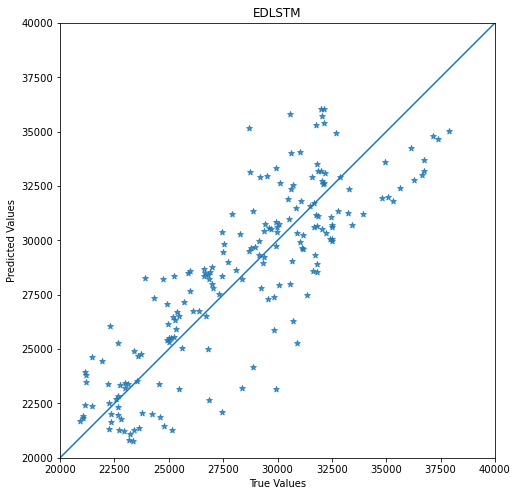

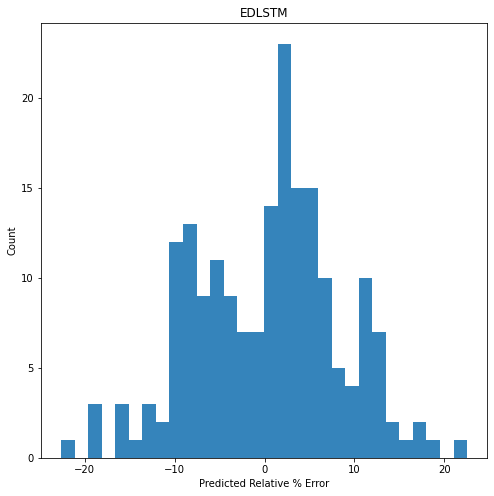

In [ ]:
fig = plot_accuracy(eval_df2,model_type,f"./{model_type}/accuracy2_{namespace}.png")
fig.show()
fig = plot_error_variations(eval_df2,model_type,f"./{model_type}/error_variations2_{namespace}.png")
fig.show()

# Conclusion and outlook
